In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib
from datadude import readfile

In [137]:
ls "../results/08_refactoring/"

08_refactoring.py  out/  plots/


In [51]:
df = pd.read_csv("09_output.csv",index_col=0)
df.date = pd.to_datetime(df.date)

In [96]:
member = "01"
exp = "ref"
sim_base_dir = "/wolke_scratch/enzb/ICON/output/sim_13k_largedomain"
sim_params = dict(
    member=member,
    exp=exp,
    indir="{sim_base_dir}/2013_{member}_{exp}/remap/".format(
        sim_base_dir=sim_base_dir, member=member, exp=exp
    ),
    indir2="{sim_base_dir}/2013_{member}_{exp}/remap/".format(
        sim_base_dir=sim_base_dir, member=member, exp=exp
    ),
    inbase="REMAP_NWP_LAM_DOM01_",
    inbase2="REMAP_NWP_LAM_PL_T_DOM01_",
)
tc_params = dict(
    slpdis=50000,  # minimum distance between two slp minima
    maxlat=45,  # maximum latitude that is considered in degrees
    vormin=1e-5,  # minimum vorticity to pass as TC
    temdif=1,  # temperature difference of warm core
    temdis=200000,  # distance at which location is considered "environment"
    winddis=100000,  # distance within which to look for wind maximum
    maxhgt=3000,  # maximum height where mind maximum is searched
    res=0.125,  # resolution in degrees
)

In [91]:
datetime = df[df["lon"] == df["lon"].max()].groupby("date")["tc_id"].count().idxmax()

In [92]:
tc_data = readfile(sim_params, datetime)

attempting to read file /wolke_scratch/enzb/ICON/output/sim_13k_largedomain/2013_01_ref/remap/REMAP_NWP_LAM_DOM01_20130917T000000Z.nc
attempting to read file /wolke_scratch/enzb/ICON/output/sim_13k_largedomain/2013_01_ref/remap/REMAP_NWP_LAM_PL_T_DOM01_20130917T000000Z.nc


In [93]:
def msk(arr, msk_arr):
    return arr[tem == np.ma.masked]    

In [95]:
crit = df[df.date == datetime]
crit

tc_id       date  lon_idx  lat_idx     lon     lat            slp  \
372    178 2013-09-17      828      521 -16.500  65.125   99940.343750   
386    179 2013-09-17      579      246 -47.625  30.750   96770.914062   
403    181 2013-09-17      832      444 -16.000  55.500  100310.796875   
404    181 2013-09-17      832      463 -16.000  57.875   99922.875000   
405    181 2013-09-17      832      469 -16.000  58.625   99919.515625   
406    181 2013-09-17      829      494 -16.375  61.750   99501.812500   

       maxwind  curr_cat  cat  
372  31.278767         0    1  
386  40.993343         1    2  
403  35.974400         1    4  
404  41.841785         1    4  
405  40.306221         1    4  
406  45.506035         2    4

In [104]:
tem.shape

(561, 841)

In [140]:
i = 494
j = 829
top = max(i - nind, 0)
bottom = min(i + nind, tem.shape[0])
left = max(j - nind, 0)
right = min(j + nind, tem.shape[1])
area = tem[top:bottom, left:right]

In [150]:
(area == np.ma.masked).data.any()

True

In [132]:
atem

230.5821963028169

In [133]:
tem[i,j]

231.07999

In [128]:
a = np.ma.array([1,2,3], mask=[False, True, True])
a.mean()

1.0

In [121]:
28*23

644

In [108]:
np.mean(tem[top:bottom, left:right])

232.12653028350516

In [107]:
tem[i,j]

233.80173

In [98]:
mpdeg = 2 * np.pi * 6371229 / 360
nind = round(tc_params["temdis"] / mpdeg * (1 / tc_params["res"]))
print("nind:  " + str(nind))
temdif = tc_params["temdif"]

nind:  14


In [ ]:
top = max(i - nind, 0)
bottom = min(i + nind, tem.shape[0])
left = max(j - nind, 0)
right = min(j + nind, tem.shape[1])
atem = np.mean(tem[top:bottom, left:right]) + temdif

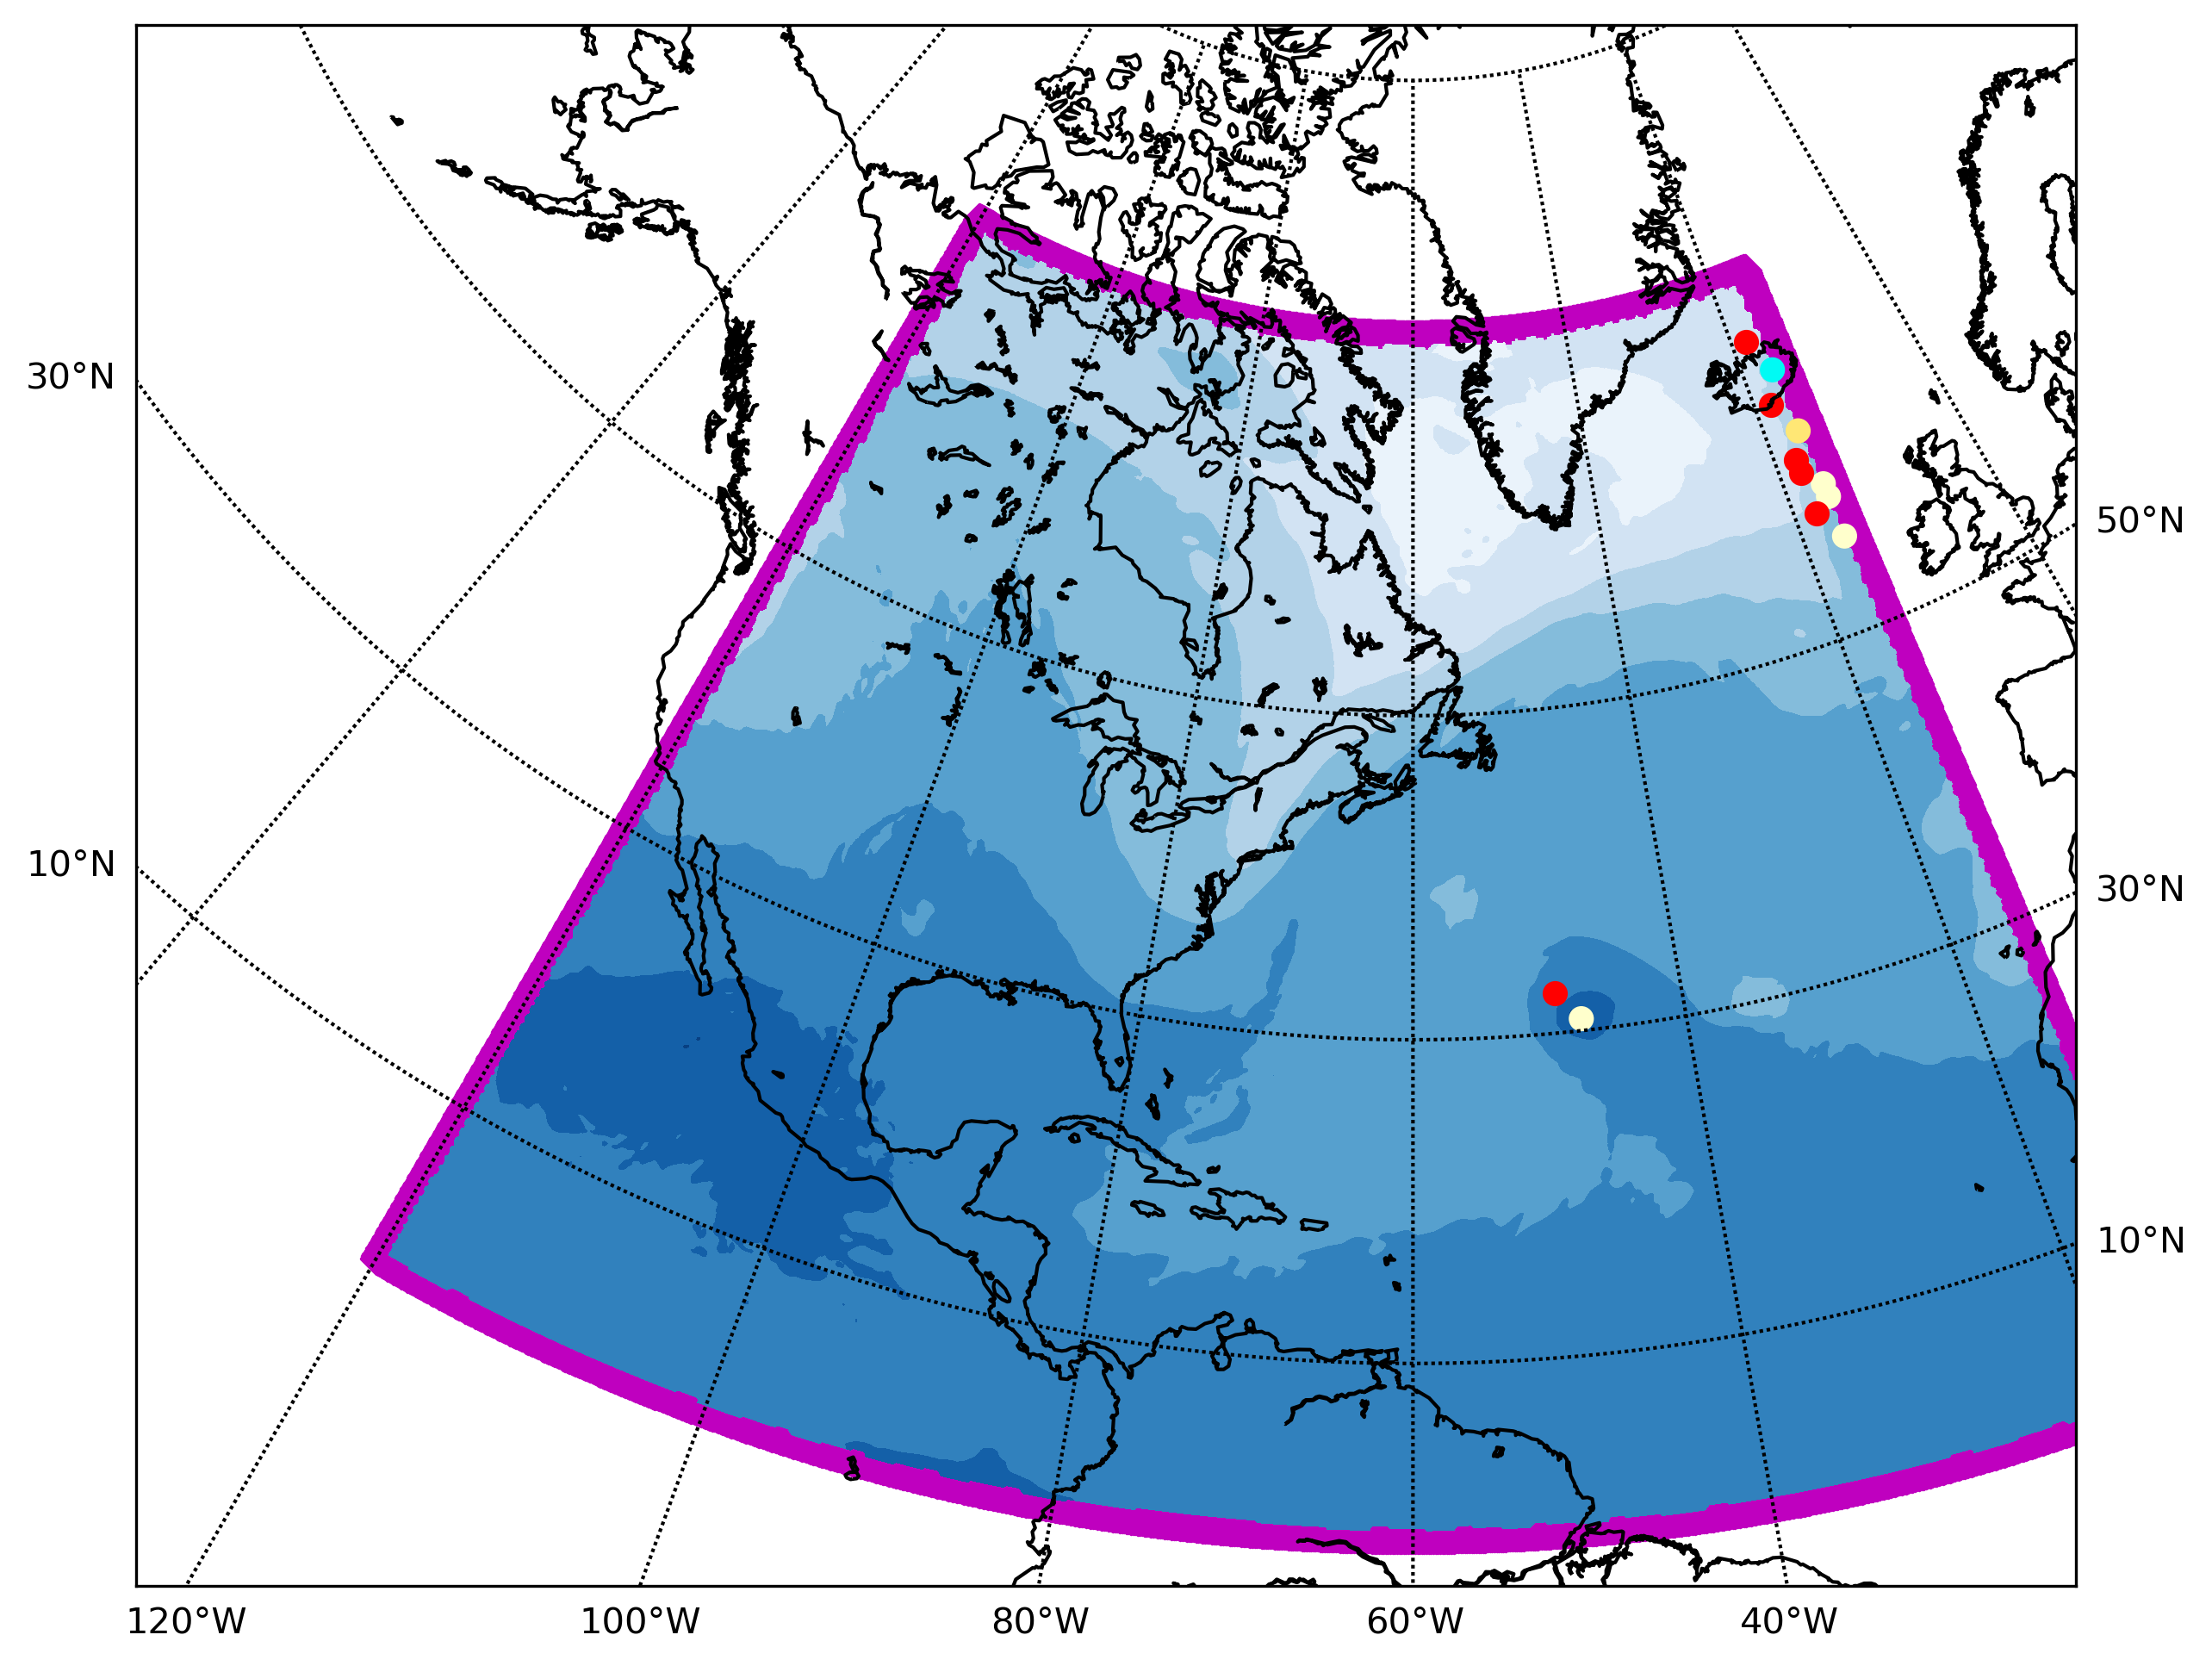

In [148]:
exp = "ref"
shad = "intensity"
tem = tc_data["tem"]
cmp = {-1: "#5ebaff",
      0:"#00faf4",
       1:"#ffffcc",
       2:"#ffe775",
       3:"#ffc140",
       4:"#ff8f20",
       5:"#ff6060"
      }

plt.figure(figsize=(12, 8),dpi=300)
mp = Basemap(
    llcrnrlon=-122.0,
    llcrnrlat=-20.0,
    urcrnrlon=40.0,
    urcrnrlat=70.0,
    projection="lcc",
    lat_1=20.0,
    lat_2=40.0,
    lon_0=-60.0,
    resolution="l",
    area_thresh=1000.0,
)
mp.drawcoastlines()
mp.drawparallels(np.arange(10, 70, 20), labels=[1, 1, 0, 0])
mp.drawmeridians(np.arange(-140, 20, 20), labels=[0, 0, 0, 1])

xx, yy = np.meshgrid(tc_data["lon"], tc_data["lat"])
xx, yy = mp(xx,yy)
mp.scatter(msk(xx, tem),msk(yy,tem),marker='D',color='m')
mp.contourf(xx,yy,tem,cmap='Blues')

lon = df[df.date == datetime]["lon"].values
lat = df[df.date == datetime]["lat"].values
categories = df[df.date == datetime]["curr_cat"]
x, y = mp(lon, lat)
colors = [cmp[cat] for cat in categories]
labels = ["Cat: {}".format(cat) for cat in categories]
mp.scatter(x, y, color=colors,label=labels)

lon_idx = df[df.date == datetime]["lon_idx"].values - 14
lat_idx = df[df.date == datetime]["lat_idx"].values + 14
lon = tc_data["lon"][lon_idx]
lat = tc_data["lat"][lat_idx]

x, y = mp(lon, lat)
mp.scatter(x, y, color="r")
plt.show()

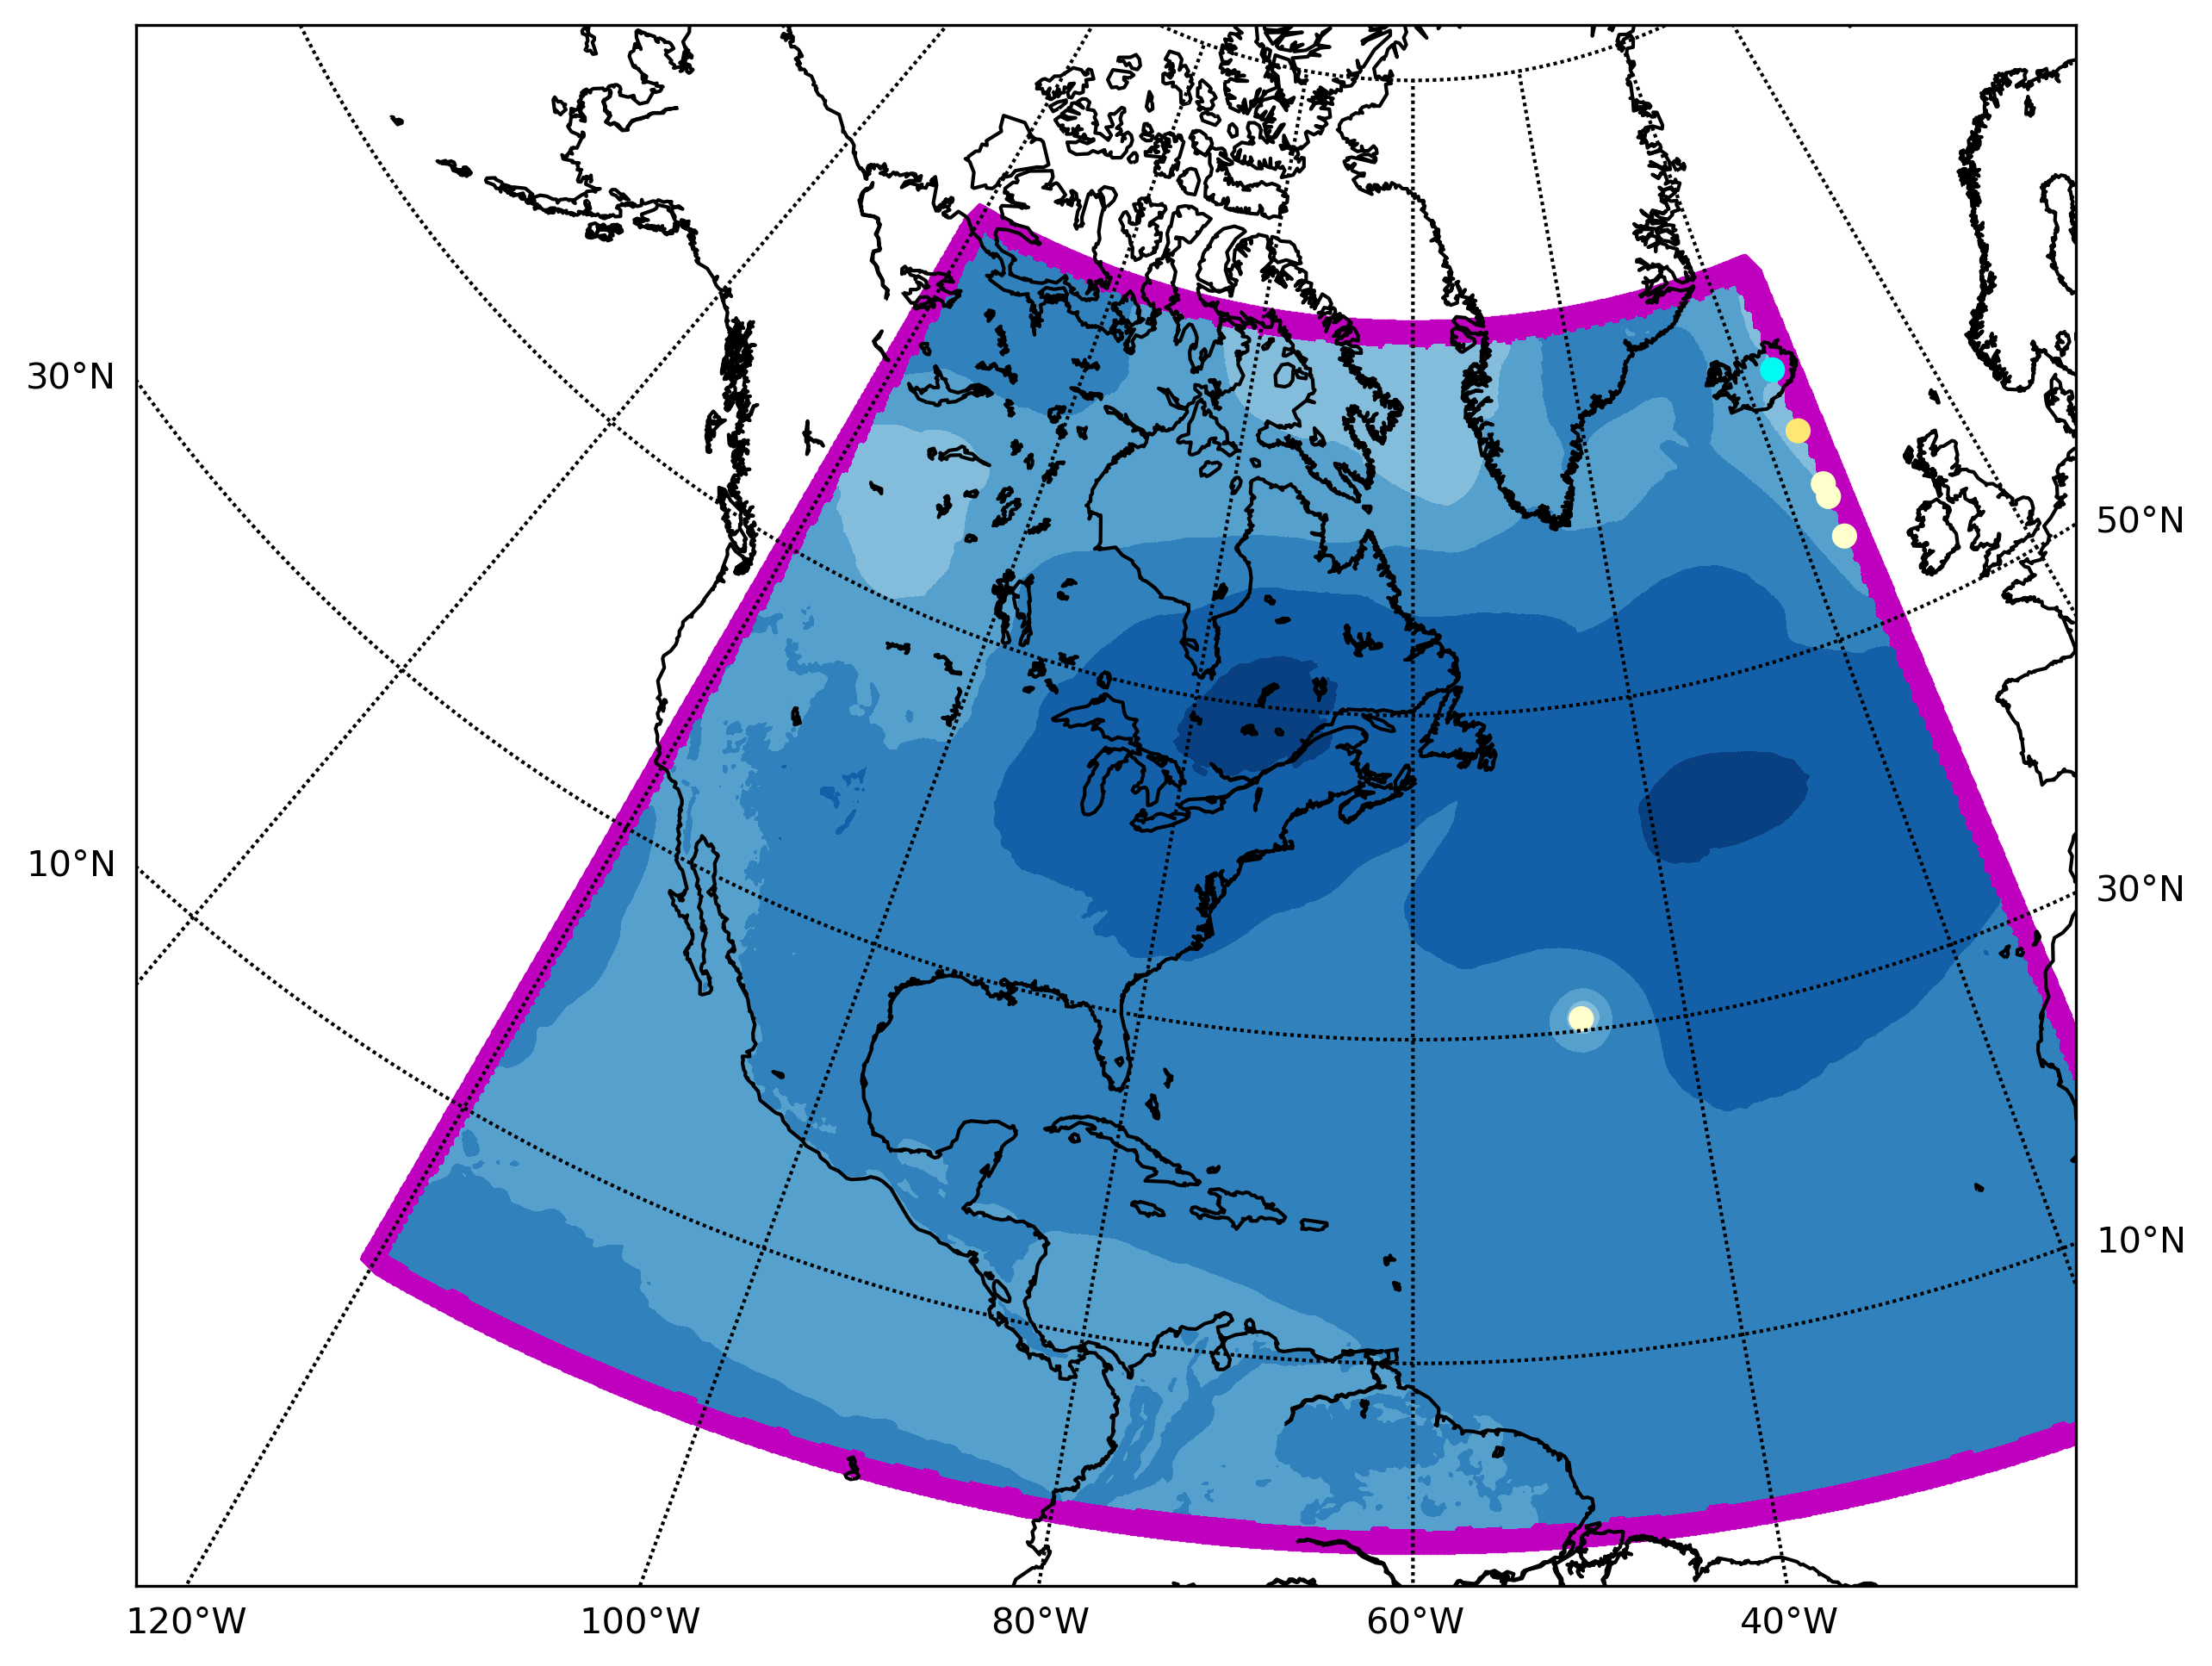

In [138]:
exp = "ref"
shad = "intensity"
slp = tc_data["slp"]
cmp = {-1: "#5ebaff",
      0:"#00faf4",
       1:"#ffffcc",
       2:"#ffe775",
       3:"#ffc140",
       4:"#ff8f20",
       5:"#ff6060"
      }

plt.figure(figsize=(12, 8),dpi=300)
mp = Basemap(
    llcrnrlon=-122.0,
    llcrnrlat=-20.0,
    urcrnrlon=40.0,
    urcrnrlat=70.0,
    projection="lcc",
    lat_1=20.0,
    lat_2=40.0,
    lon_0=-60.0,
    resolution="l",
    area_thresh=1000.0,
)
mp.drawcoastlines()
mp.drawparallels(np.arange(10, 70, 20), labels=[1, 1, 0, 0])
mp.drawmeridians(np.arange(-140, 20, 20), labels=[0, 0, 0, 1])

xx, yy = np.meshgrid(tc_data["lon"], tc_data["lat"])
xx, yy = mp(xx,yy)
mp.scatter(msk(xx, slp),msk(yy,slp),marker='D',color='m')
mp.contourf(xx,yy,slp,cmap='Blues')

lon = df[df.date == datetime]["lon"].values
lat = df[df.date == datetime]["lat"].values
categories = df[df.date == datetime]["curr_cat"]
x, y = mp(lon, lat)
colors = [cmp[cat] for cat in categories]
labels = ["Cat: {}".format(cat) for cat in categories]
mp.scatter(x, y, color=colors,label=labels)
plt.show()

In [21]:
df.groupby("tc_id").filter(lambda x: len(x) > 4)["tc_id"].unique().shape
df.groupby("tc_id").filter(lambda x: len(x) > 0)["tc_id"].unique().shape

(44,)

longitude, höherer Index, => weiter rechts
latitutde, hörerer Index, => weiter oben